### Домашняя работа №5  «Проблема качества данных»

1. Получите и загрузите данные.  
2. Удалите все пропущенные значения и категориальные переменные. Обучите модель. Выберете и посчитайте метрику качества.  
3. Снова загрузите полные данные.  
4. Удалите признаки, которые логически не нужны для построения модели. Обоснуйте.  
5. Проверьте данные на наличие пропущенных значений.  
    a) Посчитайте, какой процент данных будет потерян, если просто удалить пропуски.  
    b) Заполните пропуски: средним значением; константой; классом, указывающим на то, что значение было пропущено; случайным числом.  
    Для разных признаков используйте подходящий метод. Можно не использовать все перечисленные методы.
6. Категориальные переменные переведите в цифровые значения. Можно использовать `pd.get_dummies, preprocessing.LabelEncoder.` Старайтесь не использовать для этой задачи циклы.
7. Проверьте данные на наличие выбросов.
    a) Удалите выбросы, если считаете это целесообразным. Обоснуйте.
8. \*Постройте 1-2 графика на выбор. Визуализация должна быть основана на исследуемых данных и быть полезной (из графика можно сделать вывод об особенностях датасета/класса/признака)
9. \*Попробуйте математически преобразовать признак Age.
10. Обучите ту же модель, что в п. 2 на преобразованных данных. Посчитайте ту же, что в п. 2 метрику.
11. Сформулируйте выводы по проделанной работе.  
    a) Кратко опишите какие преобразования были сделаны и почему.  
    b) Сравните метрики моделей из п. 2 и п. 10.  
    c) Напишите свое мнение о целесообразности работы с данными при построении моделей машинного обучения. \*Нужно ли аналогичным образов исследовать и дополнять действительно большие данные?  
---
Для получения зачета по этому домашнему заданию, минимально, должно быть построено две модели, выведена одна метрика для каждой. В данных должны быть обработаны пропуски и категориальные значения.
Результат: применены на практике основные методы разведочного анализа данных (exploratory data analysis, EDA). Проведена оценка качества данных.
Форма выполнения:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from random import sample, seed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, roc_auc_score, auc)

In [2]:
le = LabelEncoder()
seed(1)

Предварительно создаем функции для обучения и оценки моделей

In [3]:
def get_prediction(m, df, target):
    y = df[target]
    X = df.drop([target], axis = 1) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = m
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    score_train = model.score(X_train_st, y_train)
    y_proba = model.predict_proba(X_test_st)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_auc_score_ = roc_auc_score(y_test, y_proba)
    return y_test, y_pred, y_proba, score_train, threshold, roc_auc_score_, fpr, tpr, roc_auc

In [4]:
def get_metrics(*data):
    metrics = {}
    metrics['Accuracy train'] = f'{data[0][3]:.2%}'
    metrics['Accuracy test'] = f'{(accuracy_score(data[0][0], data[0][1])):.2%}'
    metrics['Precision'] = f'{(precision_score(data[0][0], data[0][1])):.2%}'
    metrics['Recall'] = f'{(recall_score(data[0][0], data[0][1])):.2%}'
    metrics['F1'] = f'{(f1_score(data[0][0], data[0][1])):.2%}'
    metrics['ROC-AUC'] = f'{data[0][-4]:.2%}'
    cm = confusion_matrix(data[0][0], data[0][1])
    tn, fp, fn, tp = cm.ravel()
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Матрица ошибок')
    plt.show()
    print(f'True negative = {tn}\nFalse positive = {fp}\nFalse negative = {fn}\nTrue positive = {tp}')
    display(pd.Series(metrics))

In [5]:
def get_boxplot(data, ycolumn, xcolumn, title='', showfliers=True):
    plt.figure(figsize=(10,4))
    sns.boxplot(data=data, 
                y=ycolumn, 
                x=xcolumn,
                showfliers=showfliers, 
                showmeans=True, 
                width=.3,
                meanprops={'marker':'o', 
                           'markerfacecolor':'white',
                           'markeredgecolor':'black',
                           'markersize':'5'})
    plt.title(f'Распределение {title}',fontsize=10)
    plt.ylabel(ycolumn,fontsize=10)
    plt.xticks(fontsize=8, rotation=45)
    plt.xlabel(xcolumn,fontsize=10)
    sns.despine()
    plt.show()

#### 1. Загрузка данных

In [6]:
data_base = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

In [7]:
display(data_base.head())
display(data_base.shape)
data_base.info()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


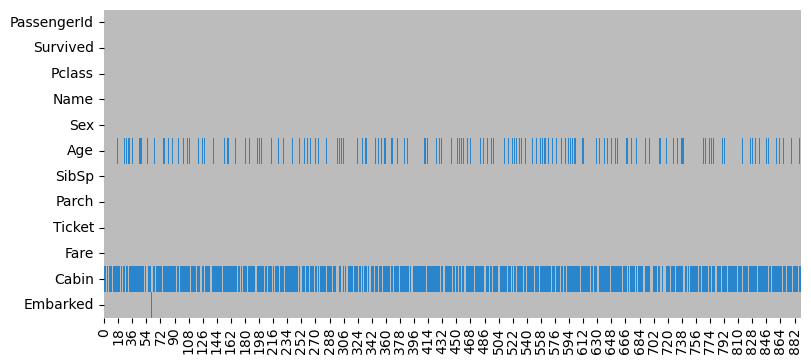

In [8]:
plt.figure(figsize=(9, 4))
colours = ['#bcbcbc', '#2986cc'] 
sns.heatmap(data_base[data_base.columns].isnull().T, cmap=sns.color_palette(colours), cbar=False)
plt.show()

In [9]:
pd.concat([data_base.isnull().sum().rename('cnt'), round((data_base.isna().mean() * 100),2).rename('%')], axis=1)

,cnt,%
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,177,19.87
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,0,0.00


In [10]:
data_base.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Довольно много пропусков в номерах кают и возрастах. В данных о стоимости билетов есть нули. Формально это не пропуски, но все равно не логично.

#### 2. Обучение и оценка модели на категориальных признаках с удаленными пропусками

In [11]:
data_lite = data_base.copy()

Проверим на сколько сократится датасет при сплошном удалении пропусков

In [12]:
print(f'Останется строк: {-data_lite.isnull().sum(axis=1).where(lambda x : x!=0).dropna().count() + data_lite.shape[0]}')
print(f'Процент перерь: {data_lite.isnull().sum(axis=1).where(lambda x : x!=0).dropna().count() / data_lite.shape[0]:.2%}')

Останется строк: 183
Процент перерь: 79.46%


In [13]:
data_lite.dropna(inplace=True)
data_lite.drop(columns=['PassengerId', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], inplace=True)
display(data_lite.head())
display(data_lite.shape)
data_lite.info()

,Survived,Age,SibSp,Parch,Fare
1,1,38.0,1,0,71.2833
3,1,35.0,1,0,53.1000
6,0,54.0,0,0,51.8625
10,1,4.0,1,1,16.7000
11,1,58.0,0,0,26.5500


(183, 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 1 to 889
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  183 non-null    int64  
 1   Age       183 non-null    float64
 2   SibSp     183 non-null    int64  
 3   Parch     183 non-null    int64  
 4   Fare      183 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 8.6 KB


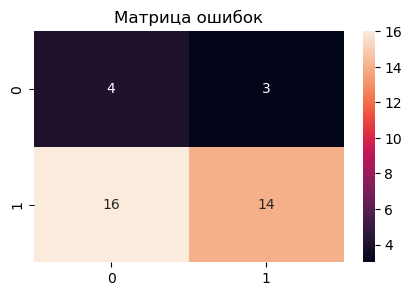

True negative = 4
False positive = 3
False negative = 16
True positive = 14


Accuracy train    61.64%
Accuracy test     48.65%
Precision         82.35%
Recall            46.67%
F1                59.57%
ROC-AUC           60.95%
dtype: object

In [14]:
get_metrics(get_prediction(LogisticRegression(class_weight='balanced'), data_lite, 'Survived'))

При такой схеме обработки данных модель сильно переобучается и имеет очень плохие метрики. Судя по ROC-AUC предсказания немногим выше случайных результатов. Это обусловлено сильным сокращением датасета по стокам и признакам.

#### 3. Обучение и оценка модели на предобработанном датасете

In [15]:
data_pro = data_base.copy()

Про предыдущему пункту известно что наименьшее количество пропусков в __Embarked__, потом идет__Age__, самое большое количество у  __Cabin__. 

Пропуски в портах заполним по самому часто встречающемуся порту в имеющихся данных о классах обслуживания. Судя по графику это Саусгэмптон.  
Заполним пропуски в значении __Embarked__ модами по сгруппированным классам

<Figure size 700x500 with 0 Axes>

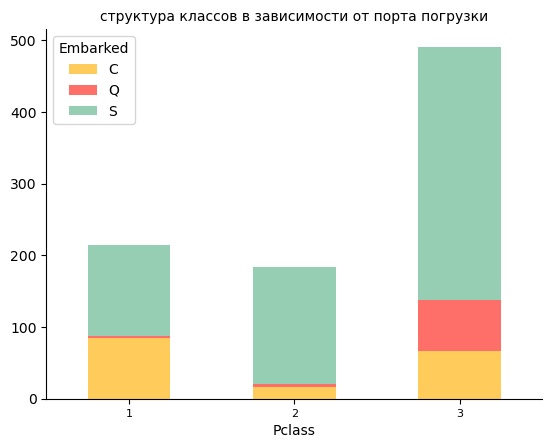

In [16]:
fig = plt.figure(figsize=(7,5))
data_pro.pivot_table(
    index='Pclass', #Pclass
    columns='Embarked', 
    values='PassengerId', 
    aggfunc='count').plot(kind='bar', stacked=True, color=['#ffcc5c', '#ff6f69', '#96ceb4'])
plt.title('структура классов в зависимости от порта погрузки',fontsize=10)
plt.xticks(fontsize=8, rotation=0)
sns.despine()
plt.show()

In [17]:
data_pro.groupby(['Pclass'])['Embarked'].apply(lambda x: x.mode()[0])

Pclass
1    S
2    S
3    S
Name: Embarked, dtype: object

In [18]:
data_pro.loc[data_pro['Embarked'].isna(), 'Embarked'] = data_pro.groupby(['Pclass'])['Embarked'].transform(lambda x: x.mode()[0])

Пропуски по полю __Age__ будем заполнять по следующему алгоритму:  
1. В имени наблюдается закономерность - в начале идет фамилия, _запятая_, обращение(титул), _запятая_, все остальное  
    \*есть предположение что мисс, миссис, мистер, мастер могут отличаться в возрасте
2. Получим титулы пассажиров, 
3. Проверим какие распределения имеющихся возрастов по титулам. 
4. Сгруппируем титулы по логике  
5. Заполним пропуски в возрастах медианами по группам титулов

In [19]:
data_pro['Title'] = data_pro['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [20]:
data_pro['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

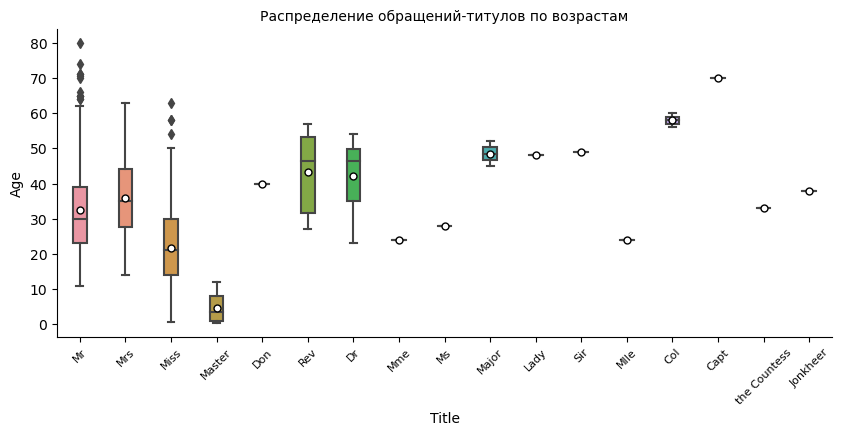

In [21]:
get_boxplot(data_pro, 'Age', 'Title', 'обращений-титулов по возрастам')

In [22]:
titles = {'Mr': 'Mr', 
          'Miss': 'Miss',
          'Mrs': 'Mrs', 
          'Master': 'Master', # обращение к мальчикам в Англии 19 века
          'Dr': 'Dr', # научное звание
          'Rev': 'Rev', # преподобный
          'Mlle': 'Miss', # фрацузская Miss
          'Major': 'Militar', # майор
          'Col': 'Militar', # полковник
          'the Countess': 'Nobility', 
          'Capt': 'Militar', # капитан
          'Ms': 'Miss', # сокращенно Miss
          'Sir': 'Nobility', 
          'Lady' : 'Nobility', 
          'Mme': 'Mrs', # американская Mrs
          'Don' : 'Mr', # испанский Mr
          'Jonkheer': 'Nobility'}

In [23]:
data_pro['Title'] = data_pro['Title'].map(titles)

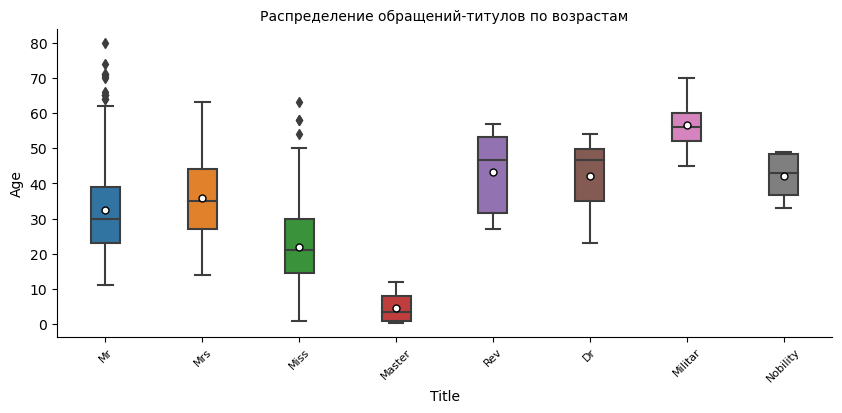

In [24]:
get_boxplot(data_pro, 'Age', 'Title', 'обращений-титулов по возрастам')

In [25]:
data_pro.loc[data_pro['Age'].isna(), 'Age'] = data_pro.groupby(['Title'])['Age'].transform('median')

Пропусков в __Cabin__ больше всего. Есть информация что списки пассажиров по каютам были найдены после крушения у погибшего стюарда. Эти списки касались лишь первого класса. Сгруппируем классы по количеству известных кают и количеству пассажиров

In [26]:
data_pro.groupby(['Pclass'] ).agg({'Cabin':'count', 'PassengerId':'count'})

,Cabin,PassengerId
Pclass,,
1,176,216
2,16,184
3,12,491


Действительно, информация о каютах имеется в основном для первого класса. Поскольку нам номер палубы или другая информация в номере каюты мало чем поможет просто заменим этот признак на бинарный есть/нет

In [27]:
data_pro['Cabin'] = data_pro['Cabin'].apply(lambda x: 0 if x is np.nan else 1)

Нулевые стоимости билетов так же стоит преобразовать. Предположим что стоимость зависит от возраста пассажира и титула. 
1. Предварительно разобьем возраст на бины
2. Проверим как цены распределены по этим бинам
3. Заменим нули медианными значениями цен по возрастным группам и титулам
4. Визуально распределение должно сохраниться, но уже без нулей

In [28]:
data_pro['Age_range'] = pd.cut(data_pro['Age'], [0,3,20,30,55, np.inf])

In [29]:
data_pro.loc[data_pro['Fare'] == 0][['Fare', 'Title','Age_range']]

,Fare,Title,Age_range
179,0.0,Mr,"(30.0, 55.0]"
263,0.0,Mr,"(30.0, 55.0]"
271,0.0,Mr,"(20.0, 30.0]"
277,0.0,Mr,"(20.0, 30.0]"
302,0.0,Mr,"(3.0, 20.0]"
413,0.0,Mr,"(20.0, 30.0]"
466,0.0,Mr,"(20.0, 30.0]"
481,0.0,Mr,"(20.0, 30.0]"
597,0.0,Mr,"(30.0, 55.0]"
633,0.0,Mr,"(20.0, 30.0]"


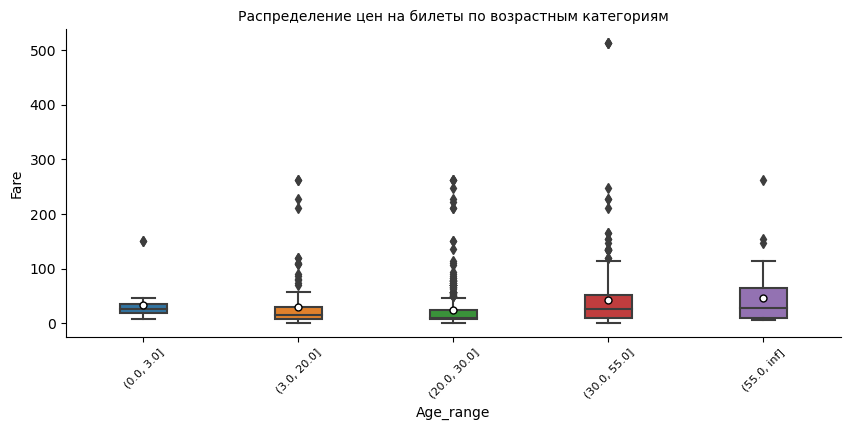

In [30]:
get_boxplot(data_pro, 'Fare', 'Age_range', 'цен на билеты по возрастным категориям')

In [31]:
data_pro.loc[data_pro['Fare'] == 0, 'Fare'] = data_pro.groupby(['Age_range', 'Title'])['Fare'].transform('median')

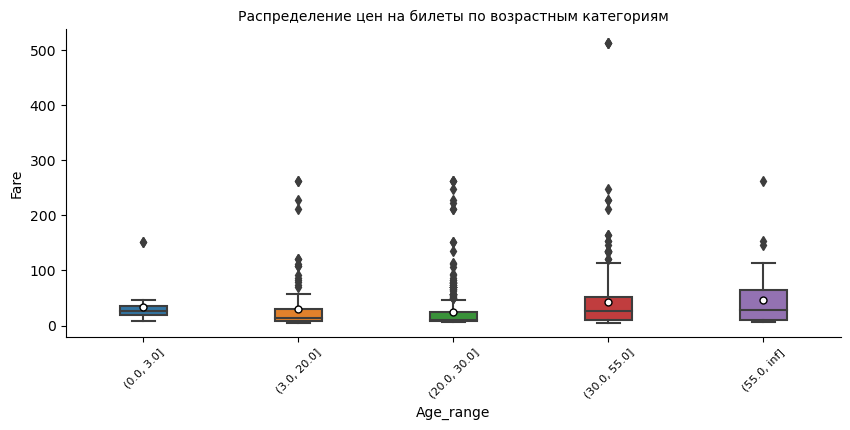

In [32]:
get_boxplot(data_pro, 'Fare', 'Age_range', 'цен на билеты по возрастным категориям')

Для полного понимания картины построим графики распределения количественных и качественных признаков

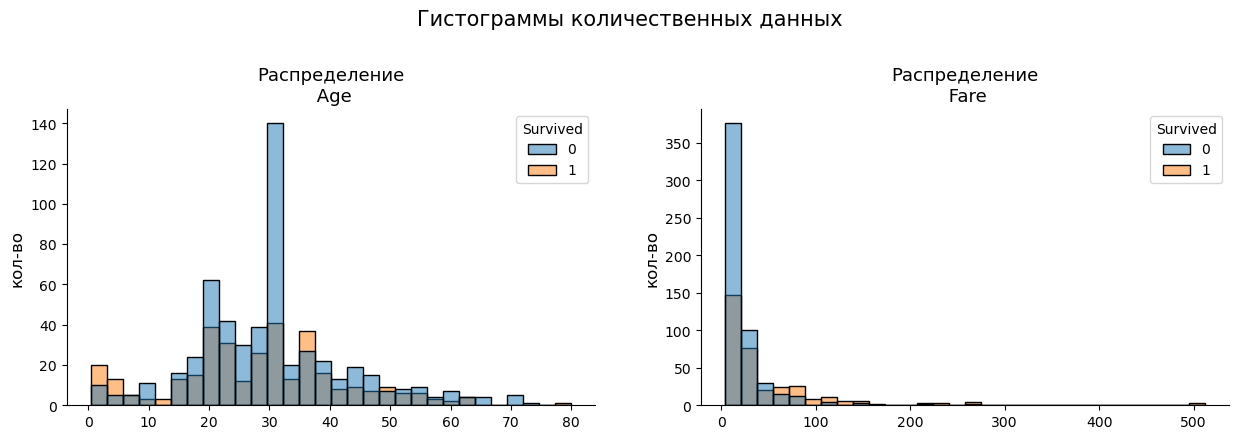

In [33]:
fig = plt.figure(figsize=(15,20))
cols = [k for k,v in data_pro.dtypes.to_dict().items() if v == 'float']
for i,col in enumerate(cols):
    fig.add_subplot(4, 2, i+1)
    sns.histplot(data=data_pro, x=col, hue='Survived', kde=False, bins=30)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('', size=12)
    sns.despine()
    plt.ylabel('кол-во', size=12)
plt.suptitle('Гистограммы количественных данных', size=15, y=0.93)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

1. По возрасту не повезло пассажирам в диапазоне от 20 до 35 лет. Там самое высокое соотношение погибших и выживших
    Среди маленьких детей соотношение в сторону выживших. такое же соотношение у 38 летних
2. По стоимости билетов среди дорогих соотношение в сторону выживших. Потому что таких билетов не особо много и они дорогие
3. Гипотезу о связи стоимости билетов возрасте и выживаемости стоит проверить.

In [34]:
data_pro.query('36 >= Age >= 34').groupby(['Survived'])['PassengerId'].count()

Survived
0    31
1    42
Name: PassengerId, dtype: int64

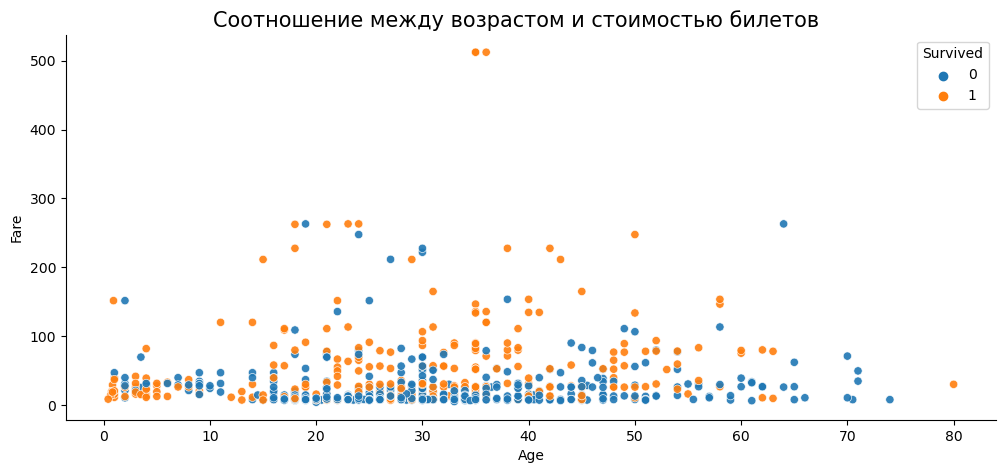

In [35]:
fig = plt.figure(figsize=(12,5))
sns.scatterplot(
    data=data_pro, 
    y='Fare', x='Age', hue='Survived', alpha=0.9)
plt.suptitle('Соотношение между возрастом и стоимостью билетов', size=15, y=0.93)
sns.despine()
plt.show()

Примечательно что пассажиры с дешевыми билетами практически все погибли, исключая детей. У обладателей более дорогих билетов шансов больше

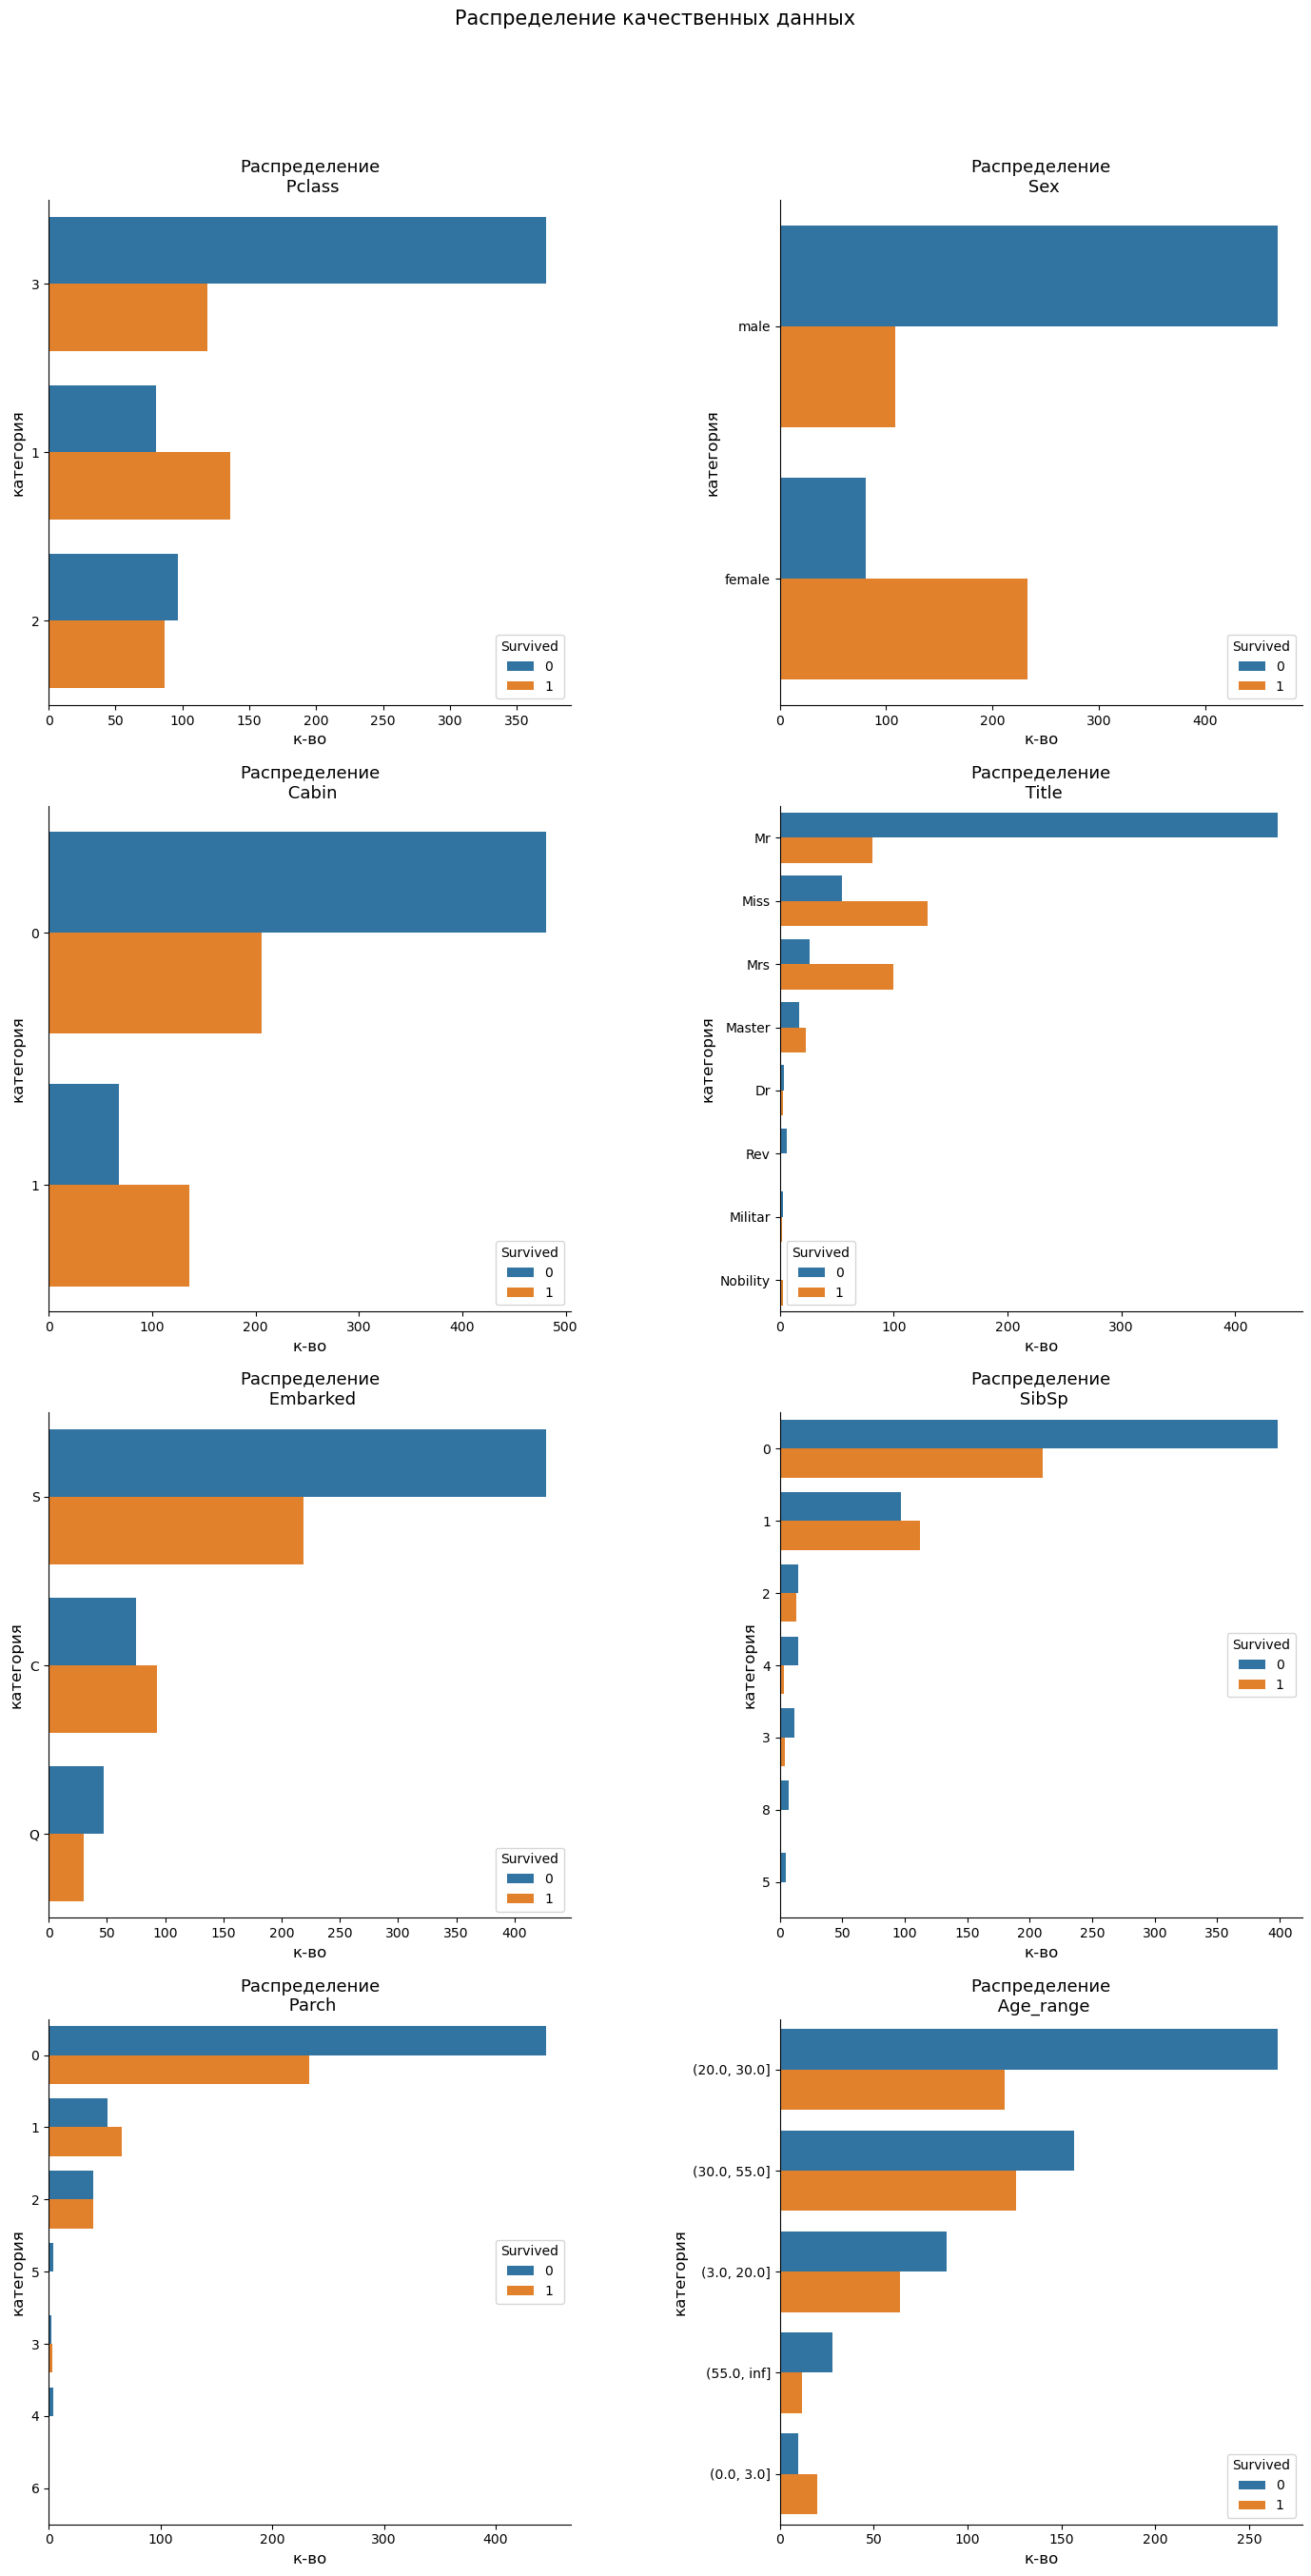

In [36]:
fig = plt.figure(figsize=(17,40))
cols = ['Pclass', 'Sex', 'Cabin', 'Title', 'Embarked', 'SibSp', 'Parch', 'Age_range']
for i,col in enumerate(cols):
    fig.add_subplot(5, 2, i+1)
    sns.countplot(data=data_pro, y=col, order = data_pro[col].value_counts().index, hue='Survived', linewidth=1)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('к-во', size=12)
    sns.despine()
    plt.ylabel('категория', size=12)
plt.suptitle('Распределение качественных данных', size=15, y=0.93)
plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show()

Распределения категориальных признаков показывают следующее:
1. У пассажиров первого класса было больше шансов выжить, второго поровну, третьего меньше
2. У женщин заметно больше шансов выжить
3. У титулов женского пола больше шансов выжить. Это коррелируется с предыдущим выводом. Все священники погибли. Аристократы выжили
4. У пассажиров из Квинстона больше шансов выжить.Вспомним что там большее соотношение в сторону первого класса по сравнению с другими портами. 
5. По семейному составу, у одиноких меньше шансов выжить
6. По возрастным группам самая уязвимая группа от 20 до 30 лет. Детям до 3 лет повезло больше (это не удивительно). Казалось бы самая физически крепкая группа должна бы выжить в большей степени, но эти пассажиры скорее показали свою самоотверженность.

Добавим признак отвечающий на то один ли путешествует пассажир или в составе семьи

In [37]:
data_pro['Alone'] = ((data_pro['SibSp'] + data_pro['Parch']) > 1).astype('int')

In [38]:
data_pro_uncuted = data_pro.copy()

In [39]:
data_pro_uncuted.drop(columns=['PassengerId', 'Name', 'Ticket', 'Age'], inplace=True)
data_pro_uncuted = pd.get_dummies(data=data_pro_uncuted, columns=['Sex', 'Embarked', 'Title', 'Pclass', 'Age_range']).copy()

После преобразования категориальных признаков к числовым проверим корреляцию и удалим признаки с высокими значениями

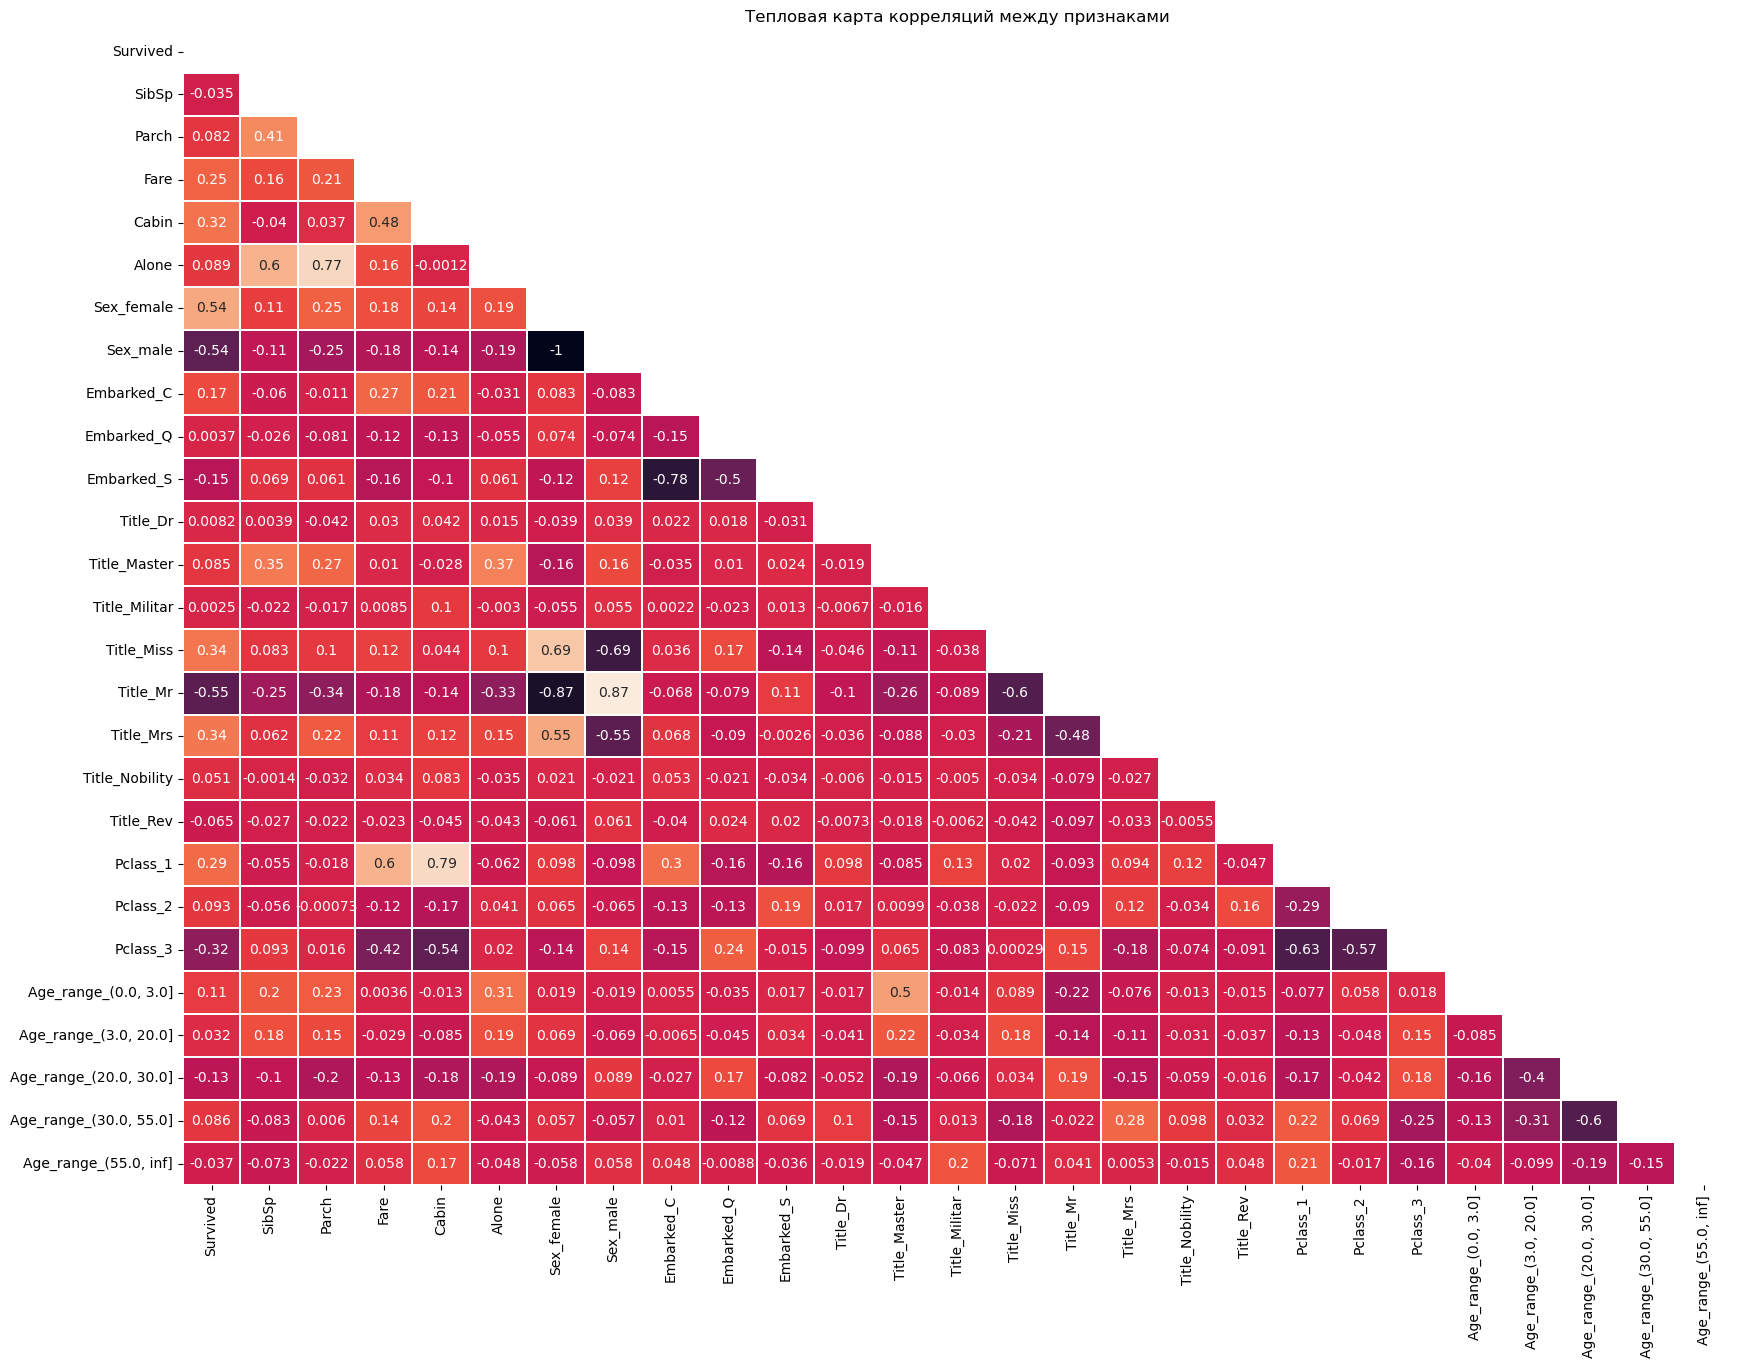

In [40]:
fig = plt.figure(figsize=(20,15))
mask = np.triu(data_pro_uncuted.corr())
sns.heatmap(data_pro_uncuted.corr(), annot=True, fmt='.2g', mask=mask, linecolor = 'white', linewidths=0.3, cbar=False)
plt.title('Тепловая карта корреляций между признаками')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [41]:
data_pro_uncuted.drop(columns=['Title_Mr', 'Pclass_1','Sex_male', 'Embarked_S'], inplace=True)

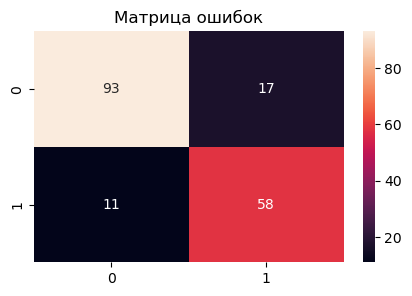

True negative = 93
False positive = 17
False negative = 11
True positive = 58


Accuracy train    81.04%
Accuracy test     84.36%
Precision         77.33%
Recall            84.06%
F1                80.56%
ROC-AUC           87.96%
dtype: object

In [42]:
get_metrics(get_prediction(LogisticRegression(class_weight='balanced'), data_pro_uncuted, 'Survived'))

Модель заметно улучшилась по сравнению с первой версией. На тестовой выборке метрика даже лучше чем на обучающей.

#### 4. Удаление выбросов

Проверим что будет если удалить выбросы ниже 5 и выше 95 персентилей

In [43]:
stat = data_pro[['Fare']].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T
stat

,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
Fare,891.0,32.408896,49.60184,4.0125,7.2292,7.925,14.4542,31.1375,112.07915,249.00622,512.3292


In [44]:
low_outler = stat.loc['Fare']['5%']
up_outler = stat.loc['Fare']['95%']

In [45]:
data_pro_cuted = data_pro.query('@low_outler < Fare < @up_outler').copy()

In [46]:
data_pro_cuted.drop(columns=['PassengerId', 'Name', 'Ticket', 'Age'], inplace=True)
data_pro_cuted = pd.get_dummies(data=data_pro_cuted, columns=['Sex', 'Embarked', 'Title', 'Pclass', 'Age_range']).copy()

In [47]:
data_pro_cuted.drop(columns=['Title_Mr', 'Pclass_1', 'Sex_male', 'Embarked_S'], inplace=True)

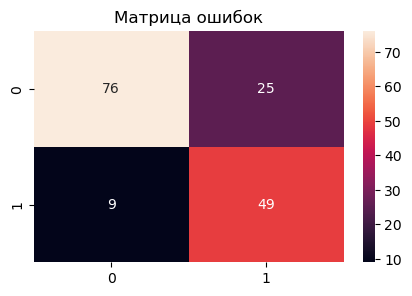

True negative = 76
False positive = 25
False negative = 9
True positive = 49


Accuracy train    81.33%
Accuracy test     78.62%
Precision         66.22%
Recall            84.48%
F1                74.24%
ROC-AUC           86.03%
dtype: object

In [48]:
get_metrics(get_prediction(LogisticRegression(class_weight='balanced'), data_pro_cuted, 'Survived'))

Метрики ухудшились. Скорее всего из за уменьшения объектов, и в особенности уменьшения вариативности. 

Как показывает практика на бОльших данных модель ведет себя лучше.  

Ответ на вопрос *"Нужно ли аналогичным образом исследовать и дополнять действительно большие данные?"* утвердительный